# Setup

In [1]:
# basic python package
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import os
import math

%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [2]:
# spark related
from pyspark.sql import DataFrameWriter
sql = sqlContext.sql

In [3]:
# spark context
sc.master

u'local[*]'

In [4]:
! ls ../../dataset/profile

_SUCCESS                  partition_time=3696969600 partition_time=3699475200


# Profile

In [5]:
profile_path = os.path.abspath('../../dataset/profile/**/*.csv')

In [6]:
profile_text = sc.textFile(profile_path)
profile_text.take(5)

[u'1,1871111837,F,D,181903,F,373933,3320438400,1217.1769900503969,528.7309192220683,Y,Y,N,N,3696969600',
 u'2,1208855837,M,C,68383,F,72631,3688502400,1717.8806412199986,3.3682296721720717,Y,N,Y,N,3696969600',
 u'3,2880263837,M,E,457653,F,93331,3692304000,1216.7107394786008,307.4304767295353,N,N,N,Y,3696969600',
 u'4,1334999837,M,L,74257,I,248503,3647980800,1414.86660231857,888.3791238333672,Y,N,N,Y,3696969600',
 u'5,2817191837,F,A,45583,I,895863,3622406400,1388.8557936778625,642.1109125464978,Y,Y,N,Y,3696969600']

## Raw data to Spark Dataframe 

In [7]:
from pyspark.sql.types import *

fields = [
    StructField('customer_id', StringType(), False),
    StructField('birth_time', LongType(), True),
    StructField('gender', StringType(), True),
    StructField('contact_loc', StringType(), True),
    StructField('contact_code', StringType(), True),
    StructField('register_loc', StringType(), True),
    StructField('register_code', StringType(), True),
    StructField('start_time', LongType(), True),
    StructField('aum', DoubleType(), True),
    StructField('net_profit', DoubleType(), True),
    StructField('credit_card_flag', StringType(), True),
    StructField('loan_flag', StringType(), True),
    StructField('deposit_flag', StringType(), True),
    StructField('wealth_flag', StringType(), True),
    StructField('partition_time', LongType(), True)
]

schema = StructType(fields)

def process_profile_line(l):
    p = l.split(',')
    # for LongType
    for i in [1, 7, 14]:
        p[i] = int(p[i])
    # for DoubleType
    for i in [8, 9]:
        p[i] = float(p[i])
    return p

profile_df = profile_text \
    .map(process_profile_line) \
    .toDF(schema=schema)
    
profile_df.show(5)

+-----------+----------+------+-----------+------------+------------+-------------+----------+------------------+------------------+----------------+---------+------------+-----------+--------------+
|customer_id|birth_time|gender|contact_loc|contact_code|register_loc|register_code|start_time|               aum|        net_profit|credit_card_flag|loan_flag|deposit_flag|wealth_flag|partition_time|
+-----------+----------+------+-----------+------------+------------+-------------+----------+------------------+------------------+----------------+---------+------------+-----------+--------------+
|          1|1871111837|     F|          D|      181903|           F|       373933|3320438400|1217.1769900503969| 528.7309192220683|               Y|        Y|           N|          N|    3696969600|
|          2|1208855837|     M|          C|       68383|           F|        72631|3688502400|1717.8806412199986|3.3682296721720717|               Y|        N|           Y|          N|    3696969600|


In [8]:
profile_df.count()

100

# Event - CCTXN

In [9]:
cctxn_text = sc.textFile(os.path.abspath('../../dataset/cctxn/**/*.csv'))
cctxn_text.take(2)

[u'customer_id,19,purchase_consumption,3696971951,merchant_nbr,QAJCHACVJNGQFXQHOKWU,credit_carde,HGSFIVCJPDGIFYNSGCMX,"{\\"action\\": {\\"txn_amt\\": 991.2349663409107, \\"original_currency_code\\": \\"TWD\\"}, \\"object\\": {\\"merchant_category_code\\": \\"07251\\"}, \\"channel\\": {\\"card_type\\": \\"C\\", \\"card_level\\": \\"3\\"}}",cc_txn,3696969600',
 u'customer_id,44,purchase_consumption,3696971951,merchant_nbr,QAJCHACVJNGQFXQHOKWU,credit_carde,HGSFIVCJPDGIFYNSGCMX,"{\\"action\\": {\\"txn_amt\\": 991.2349663409107, \\"original_currency_code\\": \\"TWD\\"}, \\"object\\": {\\"merchant_category_code\\": \\"07251\\"}, \\"channel\\": {\\"card_type\\": \\"C\\", \\"card_level\\": \\"3\\"}}",cc_txn,3696969600']

In [10]:
import json

fields = [
    StructField('actor_type', StringType(), False),
    StructField('actor_id', StringType(), True),
    StructField('action_type', StringType(), True),
    StructField('action_time', LongType(), True),
    StructField('object_type', StringType(), True),
    StructField('object_id', StringType(), True),
    StructField('channel_type', StringType(), True),
    StructField('channel_id', StringType(), True),
    StructField('attrs', StringType(), True),
    StructField('theme', StringType(), True),
    StructField('partition_time', LongType(), True)
]

schema = StructType(fields)

def process_profile_line(l):
    p = l.split(',')
    # pre
    pre_fields = p[:8]
    pre_fields[3] = int(pre_fields[3])
    # post
    post_fields = p[-2:]
    post_fields[-1] = int(post_fields[-1])
    # attrs
    attrs = json.loads(','.join(p[8:-2]))
    # concat fields
    fields = pre_fields + [attrs] + post_fields
    return fields

cctxn_df = cctxn_text.map(process_profile_line).toDF(schema=schema)

cctxn_df.show(5)

+-----------+--------+--------------------+-----------+------------+--------------------+------------+--------------------+--------------------+------+--------------+
| actor_type|actor_id|         action_type|action_time| object_type|           object_id|channel_type|          channel_id|               attrs| theme|partition_time|
+-----------+--------+--------------------+-----------+------------+--------------------+------------+--------------------+--------------------+------+--------------+
|customer_id|      19|purchase_consumption| 3696971951|merchant_nbr|QAJCHACVJNGQFXQHOKWU|credit_carde|HGSFIVCJPDGIFYNSGCMX|{"action": {"txn_...|cc_txn|    3696969600|
|customer_id|      44|purchase_consumption| 3696971951|merchant_nbr|QAJCHACVJNGQFXQHOKWU|credit_carde|HGSFIVCJPDGIFYNSGCMX|{"action": {"txn_...|cc_txn|    3696969600|
|customer_id|      19|        cash_advance| 3696973833|merchant_nbr|YILQWPZJPSDQLQVRZDWF|credit_carde|QQNZOTHNADGHAZTJEPIT|{"action": {"txn_...|cc_txn|    3696969600

##  Use JSON process "attrs"

In [11]:
import json

# return to RDD for unstructured data
cctxn_attrs = cctxn_df.select("attrs").rdd.map(lambda r: r.attrs).map(lambda x: json.loads(x))
cctxn_attrs.take(3)

[{u'action': {u'original_currency_code': u'TWD',
   u'txn_amt': 991.2349663409107},
  u'channel': {u'card_level': u'3', u'card_type': u'C'},
  u'object': {u'merchant_category_code': u'07251'}},
 {u'action': {u'original_currency_code': u'TWD',
   u'txn_amt': 991.2349663409107},
  u'channel': {u'card_level': u'3', u'card_type': u'C'},
  u'object': {u'merchant_category_code': u'07251'}},
 {u'action': {u'original_currency_code': u'TWD',
   u'txn_amt': 761.7448493550429},
  u'channel': {u'card_level': u'3', u'card_type': u'E'},
  u'object': {u'merchant_category_code': u'03057'}}]

## Count the number of each card level 

In [12]:
cctxn_attrs.filter(lambda x: x['channel']['card_level'] is not None) \
    .map(lambda x: x['channel']['card_level']) \
    .map(lambda cl: (cl, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .sortBy(lambda x: -x[1]) \
    .collect()

[(u'4', 830), (u'3', 740), (u'5', 648), (u'2', 438), (u'6', 326), (u'1', 174)]

# Merge data from different theme

## ATM 

In [13]:
atm_df = sc.textFile(os.path.abspath('../../dataset/atm/**/*.csv')) \
    .map(process_profile_line) \
    .toDF(schema=schema)

atm_df.show(5)

+-----------+--------+-----------+-----------+-----------+--------------------+------------+--------------------+--------------------+-----+--------------+
| actor_type|actor_id|action_type|action_time|object_type|           object_id|channel_type|          channel_id|               attrs|theme|partition_time|
+-----------+--------+-----------+-----------+-----------+--------------------+------------+--------------------+--------------------+-----+--------------+
|customer_id|      17|    inquire| 3696970704|saving_acct|MJQXLDJMQQOYAPFBBPBS|         ATM|NCZHYDSTABCUAXLYJLQZ|{"action": {"txn_...|  atm|    3696969600|
|customer_id|      42|    inquire| 3696970704|saving_acct|MJQXLDJMQQOYAPFBBPBS|         ATM|NCZHYDSTABCUAXLYJLQZ|{"action": {"txn_...|  atm|    3696969600|
|customer_id|       2|    inquire| 3696973691|saving_acct|NQVSLAHSTIYMZFTFVPBH|         ATM|HFJXJQTXPAMHUNCEMXBC|{"action": {"txn_...|  atm|    3696969600|
|customer_id|      27|    inquire| 3696973691|saving_acct|NQVSLA

## CTI 

In [14]:
cti_df = sc.textFile(os.path.abspath('../../dataset/cti/**/*.csv')) \
    .map(process_profile_line) \
    .toDF(schema=schema)

cti_df.show(5)

+-----------+--------+-----------+-----------+------------+---------+----------------+--------------------+--------------------+-----+--------------+
| actor_type|actor_id|action_type|action_time| object_type|object_id|    channel_type|          channel_id|               attrs|theme|partition_time|
+-----------+--------+-----------+-----------+------------+---------+----------------+--------------------+--------------------+-----+--------------+
|customer_id|      21|    inbound| 3696990924|call_purpose|  0_29_20|customer_service|personal_phone_se...|{"action": {"call...|  cti|    3696969600|
|customer_id|      46|    inbound| 3696990924|call_purpose|  0_29_20|customer_service|personal_phone_se...|{"action": {"call...|  cti|    3696969600|
|customer_id|       5|    inbound| 3696991369|call_purpose|  0_1_112|customer_service|personal_phone_se...|{"action": {"call...|  cti|    3696969600|
|customer_id|      30|    inbound| 3696991369|call_purpose|  0_1_112|customer_service|personal_phone

## MyBank 

In [15]:
mybank_df = sc.textFile(os.path.abspath('../../dataset/mybank/**/*.csv')) \
    .map(process_profile_line) \
    .toDF(schema=schema)

mybank_df.show(5)

+-----------+--------+------------------+-----------+--------------------+--------------------+------------+----------+--------------------+------+--------------+
| actor_type|actor_id|       action_type|action_time|         object_type|           object_id|channel_type|channel_id|               attrs| theme|partition_time|
+-----------+--------+------------------+-----------+--------------------+--------------------+------------+----------+--------------------+------+--------------+
|customer_id|       9|TWD_demand_deposit| 3696971762|            transfer|GMASOTHLZCPMRQIPPAFJ|     digital|    MyBank|{"action": {"amt"...|mybank|    3696969600|
|customer_id|      34|TWD_demand_deposit| 3696971762|            transfer|GMASOTHLZCPMRQIPPAFJ|     digital|    MyBank|{"action": {"amt"...|mybank|    3696969600|
|customer_id|       3|              fund| 3696974992|    general_purchase|ZSJUURIICROCLUXZPXFT|     digital|    MyBank|{"action": {"amt"...|mybank|    3696969600|
|customer_id|      28|

## Union df 

In [16]:
event_df = cctxn_df.union(atm_df).union(cti_df).union(mybank_df)

In [17]:
event_df.count()

6668

In [18]:
event_cnt_df = event_df.groupBy('actor_id').pivot('theme', ['cc_txn', 'atm', 'cti', 'mybank']).count()

In [19]:
event_cnt_df.show(5)

+--------+------+---+---+------+
|actor_id|cc_txn|atm|cti|mybank|
+--------+------+---+---+------+
|       7|    99| 10|  7|    20|
|      15|    75| 35|  2|    20|
|      11|     5|  8|  6|    36|
|      29|    67| 17|  9|     7|
|      42|    37| 69|  9|    38|
+--------+------+---+---+------+
only showing top 5 rows



# Profile with Events

In [20]:
times = profile_df \
    .select('partition_time') \
    .distinct() \
    .orderBy('partition_time') \
    .rdd.map(lambda x: x.partition_time) \
    .collect()

times

[3696969600, 3699475200]

In [21]:
start_profile_df = profile_df.where('partition_time={}'.format(times[0]))
end_profile_df = profile_df.where('partition_time={}'.format(times[1]))

In [22]:
start_profile_df.show(5)

+-----------+----------+------+-----------+------------+------------+-------------+----------+------------------+------------------+----------------+---------+------------+-----------+--------------+
|customer_id|birth_time|gender|contact_loc|contact_code|register_loc|register_code|start_time|               aum|        net_profit|credit_card_flag|loan_flag|deposit_flag|wealth_flag|partition_time|
+-----------+----------+------+-----------+------------+------------+-------------+----------+------------------+------------------+----------------+---------+------------+-----------+--------------+
|          1|1871111837|     F|          D|      181903|           F|       373933|3320438400|1217.1769900503969| 528.7309192220683|               Y|        Y|           N|          N|    3696969600|
|          2|1208855837|     M|          C|       68383|           F|        72631|3688502400|1717.8806412199986|3.3682296721720717|               Y|        N|           Y|          N|    3696969600|


In [23]:
start_profile_df.registerTempTable('start_profile')
end_profile_df.registerTempTable('end_profile')
event_cnt_df.registerTempTable('event_cnt')

In [24]:
sql("""
    select 
        a.*,
        p1.credit_card_flag as start_cc,
        p1.loan_flag as start_loan,
        p1.deposit_flag as start_deposit,
        p1.wealth_flag as start_wealth,
        p2.credit_card_flag as end_cc,
        p2.loan_flag as end_loan,
        p2.deposit_flag as end_deposit,
        p2.wealth_flag as end_wealth
    from event_cnt a
    join start_profile p1
        on a.actor_id=p1.customer_id
    join end_profile p2
        on a.actor_id=p2.customer_id
    order by actor_id
""").registerTempTable('actor_status')

In [25]:
sql("""
    select * from actor_status
""").show(5)

+--------+------+---+---+------+--------+----------+-------------+------------+------+--------+-----------+----------+
|actor_id|cc_txn|atm|cti|mybank|start_cc|start_loan|start_deposit|start_wealth|end_cc|end_loan|end_deposit|end_wealth|
+--------+------+---+---+------+--------+----------+-------------+------------+------+--------+-----------+----------+
|       1|    54| 54| 15|    15|       Y|         Y|            N|           N|     N|       Y|          Y|         N|
|      10|    34| 48| 15|    37|       N|         Y|            Y|           Y|     N|       N|          N|         Y|
|      11|     5|  8|  6|    36|       Y|         N|            N|           N|     N|       N|          Y|         Y|
|      12|    98| 70|  8|    37|       N|         N|            Y|           N|     N|       N|          N|         Y|
|      13|    59| 59|  8|    18|       Y|         Y|            N|           N|     N|       Y|          Y|         N|
+--------+------+---+---+------+--------+-------

# Play with KMeans

In [26]:
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans

In [27]:
dataset = sql("""
    select 
        actor_id,
        log(cast(cc_txn as double) + 0.0001) as cctxn_score,
        log(cast(atm as double) + 0.0001) as atm_score,
        log(cast(cti as double) + 0.0001) as cti_score,
        log(cast(mybank as double) + 0.0001) as mybank_score
    from actor_status
""")

dataset.show()

+--------+--------------------+------------------+--------------------+------------------+
|actor_id|         cctxn_score|         atm_score|           cti_score|      mybank_score|
+--------+--------------------+------------------+--------------------+------------------+
|       1|  3.9889858984144118|3.9889858984144118|  2.7080568677466546|2.7080568677466546|
|      10|   3.526363465788307|3.8712030942390543|  2.7080568677466546| 3.610920615343275|
|      11|   1.609457912234103|2.0794540416017115|  1.7917761357558344|3.5835217162300297|
|      12|   4.584968499078214| 4.248496670619767|  2.0794540416017115| 3.610920615343275|
|      13|   4.077539138819537| 4.077539138819537|  2.0794540416017115| 2.890377313436288|
|      14|  3.5835217162300297|2.3979043636661395|9.999500033329732E-5| 3.135498563745785|
|      15|   4.317489446868755|3.5553509186281893|   0.693197179309987| 2.995737273541491|
|      16|   4.317489446868755| 2.833219226391856|   0.693197179309987| 3.178057997005932|

## Feature engineering + KMeans 

In [28]:
cluster_num = 2
feature_cols = ['cctxn_score', 'atm_score', 'cti_score', 'mybank_score']

# Combine selected columns to generate vector column
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features')

# Standard Scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                       withStd=True, withMean=True)

# KMeans
kmeans = KMeans(k=cluster_num, featuresCol="scaled_features", seed=1)

# pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
pipelineModel = pipeline.fit(dataset)

In [29]:
kmeans_model = pipelineModel.stages[2]
centers = kmeans_model.clusterCenters()
centers

[array([-0.07632757,  0.46174105,  0.47183624, -0.12596761]),
 array([ 0.16219608, -0.98119973, -1.00265201,  0.26768118])]

In [30]:
predicted_df = pipelineModel.transform(dataset)
predicted_df.select(['actor_id', 'cctxn_score', 'atm_score', 'cti_score', 'mybank_score', 'prediction']).show(10)

+--------+------------------+------------------+--------------------+------------------+----------+
|actor_id|       cctxn_score|         atm_score|           cti_score|      mybank_score|prediction|
+--------+------------------+------------------+--------------------+------------------+----------+
|       1|3.9889858984144118|3.9889858984144118|  2.7080568677466546|2.7080568677466546|         0|
|      10| 3.526363465788307|3.8712030942390543|  2.7080568677466546| 3.610920615343275|         0|
|      11| 1.609457912234103|2.0794540416017115|  1.7917761357558344|3.5835217162300297|         1|
|      12| 4.584968499078214| 4.248496670619767|  2.0794540416017115| 3.610920615343275|         0|
|      13| 4.077539138819537| 4.077539138819537|  2.0794540416017115| 2.890377313436288|         0|
|      14|3.5835217162300297|2.3979043636661395|9.999500033329732E-5| 3.135498563745785|         1|
|      15| 4.317489446868755|3.5553509186281893|   0.693197179309987| 2.995737273541491|         1|


In [31]:
X = predicted_df.rdd.map(lambda r: r.scaled_features.toArray()).collect()
y = predicted_df.rdd.map(lambda r: r.prediction).collect()

In [32]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((50, 4), (50,))

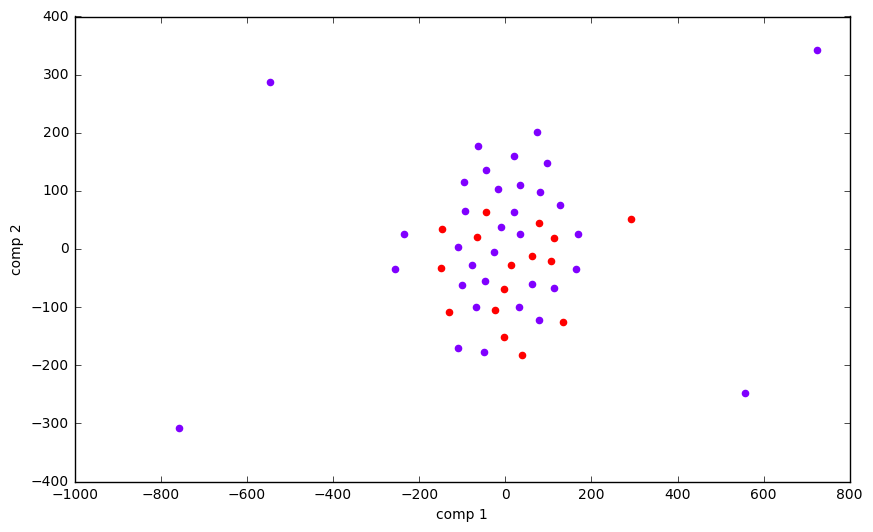

In [33]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, cluster_num))
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
points = tsne.fit_transform(X)
plt.figure(figsize=(10, 6))
plt.xlabel('comp 1')
plt.ylabel('comp 2')
for p_c in zip(points,  colors[y]):
    plt.scatter(p_c[0][0], p_c[0][1], color=p_c[1])

# Dataframe save and load

In [35]:
predicted_df.write.save("df-result", mode="overwrite", format="parquet")

In [38]:
from pyspark.sql import DataFrameReader

loaded_df = spark.read.load("df-result")

In [40]:
loaded_df.show(5)

+--------+------------------+------------------+------------------+------------------+--------------------+--------------------+----------+
|actor_id|       cctxn_score|         atm_score|         cti_score|      mybank_score|            features|     scaled_features|prediction|
+--------+------------------+------------------+------------------+------------------+--------------------+--------------------+----------+
|      13| 4.077539138819537| 4.077539138819537|2.0794540416017115| 2.890377313436288|[4.07753913881953...|[0.22728221389367...|         0|
|      38| 4.077539138819537| 4.077539138819537|2.0794540416017115| 2.890377313436288|[4.07753913881953...|[0.22728221389367...|         0|
|      26|3.9889858984144118|3.9889858984144118|2.7080568677466546|2.7080568677466546|[3.98898589841441...|[0.15092105202209...|         0|
|      10| 3.526363465788307|3.8712030942390543|2.7080568677466546| 3.610920615343275|[3.52636346578830...|[-0.2480071667711...|         0|
|      11| 1.6094579

# Thanks for your attending HackNTU X Cathay 2017!